# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Rushad | Rakhimov | Rushad Rakhimov, November 6, 2024 | 8 | 25% |
| Member 2: | Milena | Ljusic | Milena Ljusic, November 6, 2024| 8 | 25% |
| Member 3: | Priya | Bosman | Priya Bosman, November 6, 2024 | 8 | 25% |
| Member 4: | Syem | Imtiaz | Syem Imtiaz, November 6, 2024| 8 | 25% |

# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

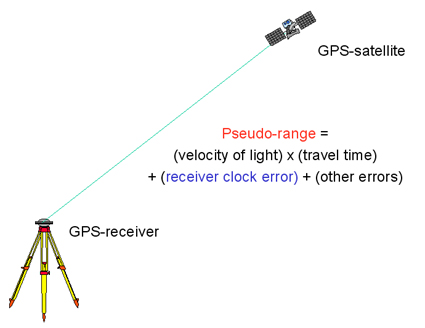

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [2]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [3]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [4]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [5]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [6]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange): 
    """ 
    This function computes the cost function of the satellite data presented, which is defined.
    It takes in the reciever position, clock offset, satellite position, and the pseudoranges for each satellite.
    This function returns a single scalar value, which is the computed cost function.
    """ 
    #determine size of pseudorange, to be used later for optimization
    n = pseudorange.size
    #compute predicted pseudoranges (distances) to each satellite
    predicted_pseudoranges = euclidean_norm(r_pos,s_pos) + cdT #calculate pseudoranges based on satellite and reciever positions

    # Calculate residuals
    residuals = pseudorange - predicted_pseudoranges #determine residuals between provided psuedoranges and calculated pseudoranges

    # Calculate sum of squared residuals
    L = (1/n)*(np.sum(residuals ** 2)) # compute cost function
    
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [7]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):

    """
    This function computes the gradient of the cost function.
    It takes in the reciever position, clock offset, satellite position, and the pseudoranges for each satellite.
    The function returens the gradient of the cost function, which is a 1-dimension array.
    The returned array contains the partial derivaties for x,y,z,and cdT, which are optimized estimates for each parameter.

    """
    #determine size of pseudorange, to be used later for optimization
    n = pseudorange.size 
    #compute predicted pseudoranges (distances) to each satellite
    predicted_pseudorange = euclidean_norm(r_pos,s_pos) + cdT

    #takes the number of columnes of the s_pos array (which will have an x,y,z column)
    num_columns = s_pos.shape[1]
    #cast to float
    num_columns_float = int(num_columns)
    #adds additional dimension to account for cdT
    grad_dimension = num_columns_float + 1 

    #generates zeros array of shape 4 x 1 (x,y,z,cdT) to be populated with values of gradient calculation
    grad = np.zeros(grad_dimension)

    #calculate residuals between calculated and provided pseudoranges
    residuals = pseudorange - predicted_pseudorange

    #compute the partial derivatives for xr, yr, zr, and cdT
    #once computed, insert residuals into blank gradient array
    xterm = residuals*((r_pos[0] - s_pos[:, 0]) / predicted_pseudorange)
    yterm = residuals*((r_pos[1] - s_pos[:, 1]) / predicted_pseudorange)
    zterm = residuals*((r_pos[2] - s_pos[:, 2]) / predicted_pseudorange)
    
    grad[0] = (-2/n)*(np.sum(xterm))
    grad[1] = (-2/n)*(np.sum(yterm))
    grad[2] = (-2/n)*(np.sum(zterm))
    grad[3] = (-2/n)*(np.sum(residuals))
    
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [8]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    """
    This function computes the gradient descent for a non-linear LSE
    This function takes the pseudorange, satellite position coordinates, learning rate, maximum iteration value, and tolerance value as arguments.
    The function returns an array of the length of the iterative cycles performed.
    
    """
    #define steps_count as a global variable
    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])
    
    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos,cdT,s_pos,pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos,cdT,s_pos, pseudorange)

        # update estimates
        # (1 mark)
        X_new = X - (learning_rate*grad)

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [9]:
#call optimized parameters, at learning rate = 0.1, and 10000 iterations
optimized_params = gradient_descent(pseudorange,sat_pos,learning_rate=0.1, max_iters=10000, tolerance=1e-6)
print("Optimized Parameters:", optimized_params)
print("Final position errors of reciever:", arr_err[-1])
print("Number of steps taken for convergence:" ,steps_count)
print("Final cost value:" ,arr_cost[-1])
print("Final gradient values:", arr_grad[-1])

Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44842179e+00]
Final position errors of reciever: [-3.06240961 -2.34633587  3.7715453 ]
Number of steps taken for convergence: 2944
Final cost value: 0.5634452430848553
Final gradient values: [ 0.00015517  0.0008646  -0.00265729 -0.00150649]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

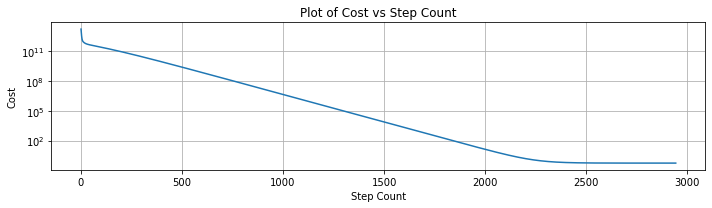

In [10]:
#plot cost as a function of steps
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

#generates list of length steps_count, at increments of 1
steps_count_axis = np.arange(0, steps_count, 1)

#cost is plotted on a log scale 
plt.semilogy(steps_count_axis, arr_cost)

# Adding labels and title
plt.title('Plot of Cost vs Step Count')
plt.xlabel('Step Count')
plt.ylabel('Cost')


ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The cost function provides information on the accuracy of the machine learning model (by comparing actual versus predicted data).
# We expect to see the cost function decrease as the number of iterations increase, which is demonstrated in the plot below.
# The decrease in the cost function reveals that the model is being trained, and accuracy is increasing.
# The cost function converges at a global minimum between 2000 and 3000 interations, displayed in the graph.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

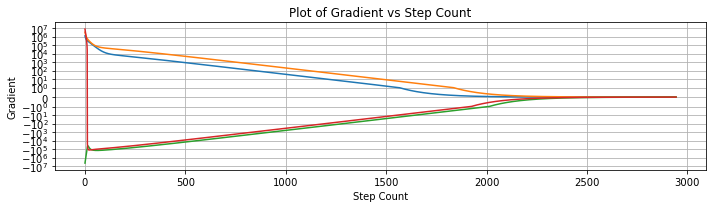

In [11]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

#generates list of length steps_count, at increments of 1
steps_count_axis = np.arange(0, steps_count, 1)

#plot gradient vs step count
plt.plot(steps_count_axis, arr_grad)
#plot y axis on a symmetric log scale
plt.yscale('symlog', linthresh=1)

# Adding labels and title
plt.title('Plot of Gradient vs Step Count')
plt.xlabel('Step Count')
plt.ylabel('Gradient')

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The gradient presented here is the derivative of the cost function
# From this plot we see the plot converging between 2000 and 3000
# This trend is anticipated, based on the cost function plot presented above.
# The trend shows that the most rapid training of the model occurs within the earlier iterations.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

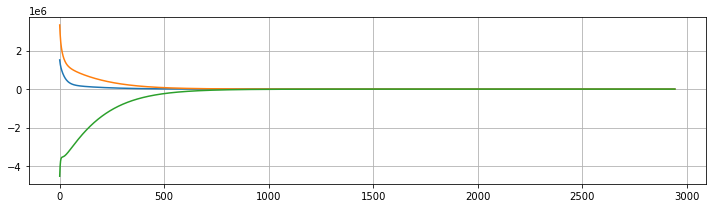

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

#generates list of length steps_count, at increments of 1
steps_count_axis = np.arange(0, steps_count, 1)

#plot gradient vs step count
plt.plot(steps_count_axis, arr_err)

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The trend plotted below indicates the rapidity at which the model is trained
# It is evident that the most profound reduction in error between true and theoretical values occurs within the with 500 iterative cycles

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [13]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0
learning_rate = 0.01

#call optimized parameters function at learning rate = 0.01, iterations = 100000
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate, max_iters=100000, tolerance=1e-6)

#print the metrics
print("Optimized Parameters:", optimized_params_2)
print("Final position errors of reciever:", arr_err[-1])
print("Number of steps taken for convergence:" ,steps_count)
print("Final cost value:" ,arr_cost[-1])
print("Final gradient values:", arr_grad[-1])

Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162950e+06  4.95248530e+06  6.39730478e+00]
Final position errors of reciever: [-3.05714451 -2.3169989   3.6813805 ]
Number of steps taken for convergence: 27703
Final cost value: 0.5641548423540386
Final gradient values: [ 0.00048857  0.00272229 -0.00836675 -0.00474335]


In [14]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

#call optimized parameters function at learning rate = 0.001, iterations = 1000000
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=1000000, tolerance=1e-6)

#print the metrics
print("Optimized Parameters:", optimized_params_3)
print("Final position errors of reciever:", arr_err[-1])
print("Number of steps taken for convergence:" ,steps_count)
print("Final cost value:" ,arr_cost[-1])
print("Final gradient values:", arr_grad[-1])

Converged !
Optimized Parameters: [-1.63349242e+06 -3.65162941e+06  4.95248502e+06  6.23556675e+00]
Final position errors of reciever: [-3.04048536 -2.22417457  3.39609241]
Number of steps taken for convergence: 258947
Final cost value: 0.5712617984682808
Final gradient values: [ 0.00154539  0.00861088 -0.02646483 -0.01500367]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

Q1: Decreasing the learning rate resulted in an increase of the iterative steps required for the model to converge. The learning rate determines how quickly the model's parameters are updated; as such, we would expected that a reduced learning rate will result in more iterations required to train the model. This hypothesis is consistent with the results we witnessed in our model, wherein at learning rate of 0.1, it required approximately 3000 iterations to converge, while at a learning rate of 0.01 we witnessed the need for 27703 iterations before the model converged, and 258947 iterations to converge at a learning rate of 0.001. We observe that the cost value shows slight variations as the learning rate is tuned; similarly, minor variances are observed between the optimized parameters and final position errors. This may indicate that the model is over/undershooting the convergence value with adjustments to the learning rate. Further testing at different learning rates may be required to determine the most accurate final parameter values.

Q2: A LSE assumes that the data can be represented by a linear model, while the gradient descent does not assume linearity. The gradient descent instead updates the model iteratively based on a defined learning rate, until it is able to converge at a local minimum, while the least squares estimation can performed iteratively or in one computational step. By comparing our results from assignment 2, the results generated for the optimized parameters/predicted states are within reasonable range of each other, which suggests that for this dataset, either method is acceptable. In both cases the model's accuracy improves with iterations, however the gradient descent method allows for tuning of the model with the learning rate, which may prove advantageous for refining the results.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [16]:
#!pip install ucimlrepo

In [17]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
data = phishing_websites.data.features.join(phishing_websites.data.targets)

# TO DO: display sizes of X and y (1 mark)
X = data.drop('result', axis=1)
y = data['result']

print(f"Size of X and y: {X.shape} and {y.shape}")

Size of X and y: (11055, 30) and (11055,)


In [18]:
data

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,-1,1,-1,1,1,1,1,-1,-1,...,-1,-1,1,1,-1,-1,1,1,1,1
11051,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,1,1,1,1,1,1,-1,1,-1
11052,1,-1,1,1,1,-1,1,-1,-1,1,...,1,1,1,1,1,-1,1,0,1,-1
11053,-1,-1,1,1,1,-1,-1,-1,1,-1,...,-1,1,1,1,1,-1,1,1,1,-1


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

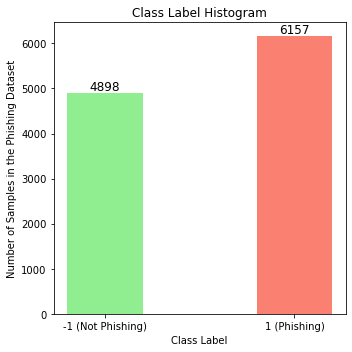

In [19]:
# TO DO: Check the class distribution of y (2 mark)
class_counts = y.value_counts()

colors = ['lightgreen' if label == -1 else 'salmon' for label in class_counts.index]
labels = ['1 (Phishing)', '-1 (Not Phishing)']

plt.figure(figsize=(5, 5))
bars = plt.bar(class_counts.index, class_counts.values, color=colors, tick_label=labels)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom', fontsize=12)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples in the Phishing Dataset')
plt.title('Class Label Histogram')    

plt.tight_layout()
plt.show()

In [20]:
# double check
data['result'].value_counts()

 1    6157
-1    4898
Name: result, dtype: int64

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [21]:
# TO DO: Create a smaller dataset with 3% of the data
X_small, X_unused, y_small, y_unused = train_test_split(
    X, y, test_size=0.97, random_state=42)

# proportion of classes in the target vector y is NOT maintained because it is not requested in the task.

# TO DO: display sizes of X_small and y_small (2 mark)
print(f"Sizes of X_small and y_small: {X_small.shape} and {y_small.shape}")

Sizes of X_small and y_small: (331, 30) and (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [22]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

def evaluate_model(X_data, y_data, model_name):
    """
    Trains and evaluates a Logistic Regression model on a given dataset.

    Args:
        X_data (pd.DataFrame): Feature matrix.
        y_data (pd.Series): Target vector.
        model_name (str): Name of the dataset for identification.

    Returns:
        dict: Model evaluation metrics including data size, 
              training samples, testing samples, training accuracy,
              testing accuracy, and log loss.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.3, random_state=0, stratify=None
    )
    
    model = LogisticRegression(max_iter=2000).fit(X_train, y_train)
    
    metrics = {
        "Dataset": model_name,
        "Data size": f"{X_data.shape[0]} rows, {X_data.shape[1]} columns",
        "Training samples": X_train.shape[0],
        "Testing samples": X_test.shape[0],
        "Training accuracy": accuracy_score(y_train, model.predict(X_train)),
        "Testing accuracy": accuracy_score(y_test, model.predict(X_test)),
        "Log loss": log_loss(y_test, model.predict_proba(X_test))
    }
    return metrics


datasets = {
    "Full Dataset": (X, y),
    "First Two Columns": (X.iloc[:, :2], y),
    "Smaller Dataset": (X_small, y_small)
}

results = pd.DataFrame([evaluate_model(X_data, y_data, name) 
                        for name, (X_data, y_data) in datasets.items()])
results

,Dataset,Data size,Training samples,Testing samples,Training accuracy,Testing accuracy,Log loss
0,Full Dataset,"11055 rows, 30 columns",7738,3317,0.932282,0.922822,0.190317
1,First Two Columns,"11055 rows, 2 columns",7738,3317,0.562807,0.556828,0.683573
2,Smaller Dataset,"331 rows, 30 columns",231,100,0.943723,0.910000,0.200467


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [23]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

from sklearn.metrics import confusion_matrix, classification_report


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=None)

model_full = LogisticRegression(max_iter=2000) # Instantiate and train the model using the full dataset
model_full.fit(X_train, y_train)

y_pred = model_full.predict(X_test)

print(f"Dimension of the predicted output: {y_pred.shape}")

Dimension of the predicted output: (3317,)


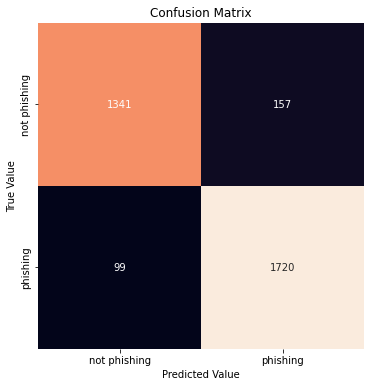

In [24]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_pred)

# Below code prints confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_mat, 
    xticklabels=['not phishing', 'phishing'], 
    yticklabels=['not phishing', 'phishing'], 
    square=True, 
    annot=True, 
    cbar=False, 
    fmt='d'
)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# TO DO: Print classification report (2 marks)
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

### Q1: Is the dataset imbalanced? Does it affect model performance?
Yes, the dataset is imbalanced (1847 phishing emails vs. 1470 non-phishing emails) but not much. This is why the main model (the one that contains most of the data) achieves good accuracy, precision, and recall.

### Q2: Does the model overfit or underfit for each of the 3 cases?
- **Full Dataset (11055 rows, 30 columns):** No overfitting (i.e. the model generalizes well).
  - Training accuracy: 93.22%, Testing accuracy: 92.28%
- **First Two Features (11055 rows, 2 columns):** Underfits due to limited features (model doesn't capture the underlying patterns in the data).
  - Training accuracy: 56.28%, Testing accuracy: 55.68%
- **Smaller Dataset (331 rows, 30 columns):** Technically, a little underfitting (due to fewer samples).
  - Training accuracy: 94.37%, Testing accuracy: 91.00%

### Q3: How do training and testing accuracy change with the amount of data used?
Training and testing accuracy improve with more features, while fewer features reduce accuracy and generalization. Number of rows don't really affect accuracy.

### Q4: What do a false positive and a false negative represent? Which is worse?
- **False Positive:** A safe email marked as phishing.
- **False Negative:** A phishing email marked as safe.  
  **False Negative** is worse, as it allows a phishing email to bypass detection.

### Q5: Should we maximize precision or recall? How?
Maximize **recall** to identify more phishing emails. Adjusting (making it lower) the model's threshold is a good way to make recall metric higher. Oversampling the phishing class is optional though not recommended as it might lower precision too much.

### Q6: What does Log Loss say about the model in each case? What causes the differences?
**Log Loss** measures how well the model's probabilities match the actual labels (lower values mean better performance).
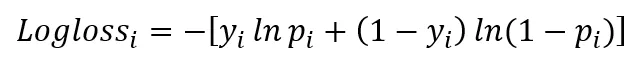
where `i` is the given observation/record, `y` is the actual/true value, `p` is the prediction probability, and ln refers to the natural logarithm (logarithmic value using base of e) of a number. <br>
- **Full Dataset (Log Loss: 0.17):** Good predictions, model works well.
- **First Two Features (Log Loss: 0.68):** Poor predictions due to limited features.
- **Smaller Dataset (Log Loss: 0.17):** Predictions are still good, despite fewer rows.